In [1]:
import pandas as pd
import numpy as np
import json 
import seaborn as sns
from pylab import mpl, plt

plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

In [2]:
def rango_percentilar(mydata, col_name, idx):
    return np.mean(mydata[f"{col_name}"].to_numpy() <= mydata[f"{col_name}"].iloc[idx])


def to_percentile(mydata, col_name):
    mydata = mydata.copy()
    mydata = mydata.reset_index()
    percentiles = [ ]
    for idx, series in mydata.iterrows():
        res = rango_percentilar(mydata, col_name, idx)
        percentiles.append(res)
    mydata[f"{col_name}_percentile"] = percentiles
    return mydata


def plot_mayer(mydata, x="time", y="price", hue="Mayer_percentile"):
    f, ax = plt.subplots(figsize=(15, 11))
    sns.despine(f, left=True, bottom=True)
    sns.scatterplot(x="time", y="price",
                    hue="Mayer_percentile", 
                    sizes=(10, 20),
                    alpha=.5,
                    palette="rocket", 
                    data=mydata, ax=ax)


<AxesSubplot:>

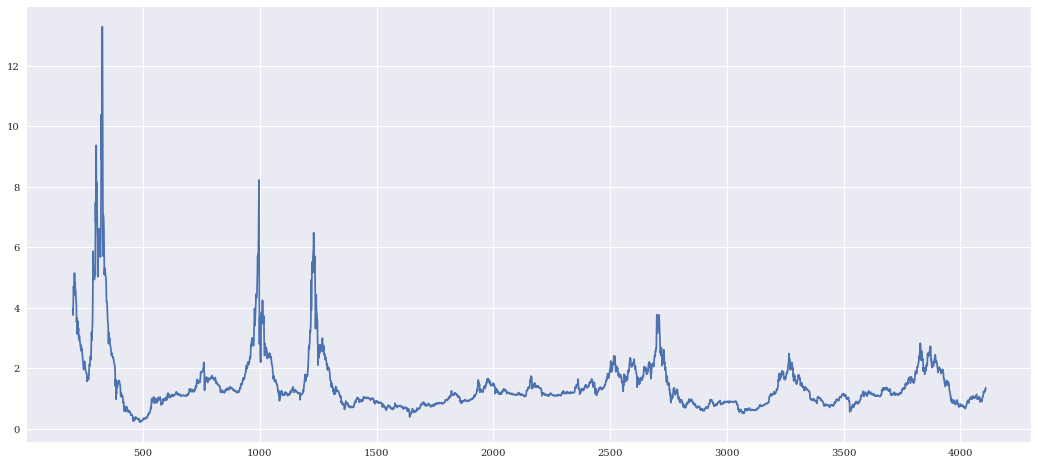

In [35]:
df = pd.read_json('./price-btc-24h.json')

df.columns = ["time", "price"]
df["time"] = pd.to_datetime(df["time"])
df.set_index("time", inplace=True)

# Mayer multpliyer
df['SMA_200'] = df['price'].rolling(200).mean()
df["Mayer"] = (df["price"])/df["SMA_200"]
df = to_percentile(df, "Mayer")
df["Mayer"].plot.line( figsize=(18,8))

<AxesSubplot:xlabel='Mayer', ylabel='Count'>

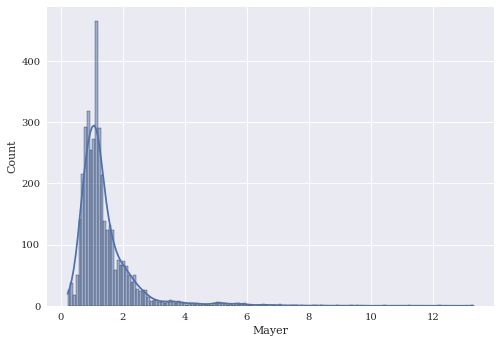

In [7]:
sns.histplot(df["Mayer"],kde=True )

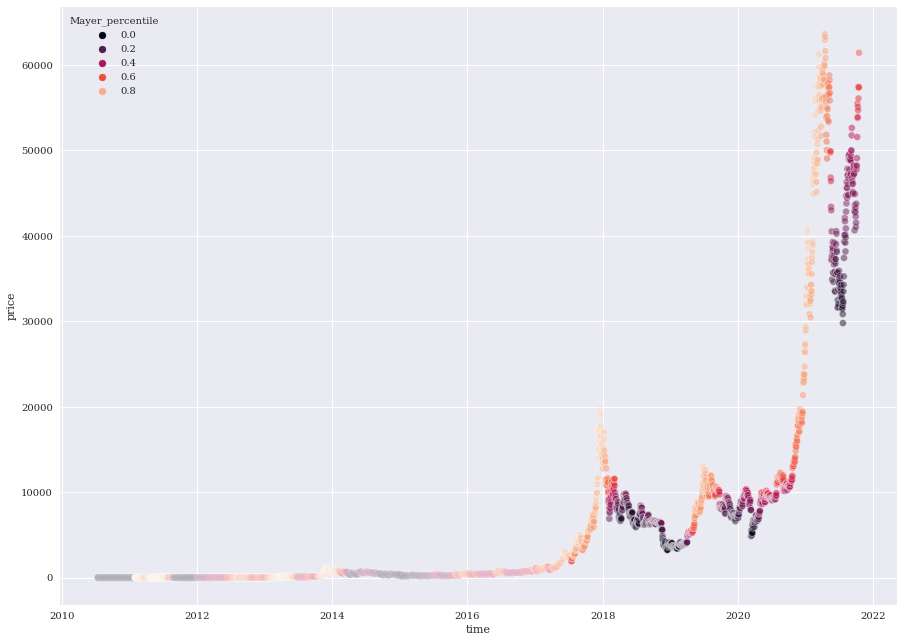

In [11]:
plot_mayer(df)  

In [114]:
df.iloc[-15:]

,time,price,SMA_200,Mayer,Mayer_percentile
4094,2021-10-01 00:00:00+00:00,48118.177706,45231.870087,1.063811,0.356048
4095,2021-10-02 00:00:00+00:00,47756.254283,45188.208246,1.056830,0.351910
4096,2021-10-03 00:00:00+00:00,48220.653037,45135.566893,1.068352,0.358725
4097,2021-10-04 00:00:00+00:00,49080.669092,45091.530832,1.088468,0.371137
4098,2021-10-05 00:00:00+00:00,51559.362044,45057.456608,1.144303,0.446581
4099,2021-10-06 00:00:00+00:00,55431.027002,45042.394136,1.230641,0.539304
4100,2021-10-07 00:00:00+00:00,53776.542871,45023.669567,1.194406,0.505963
4101,2021-10-08 00:00:00+00:00,53884.290533,45020.049724,1.196895,0.508640
4102,2021-10-09 00:00:00+00:00,55068.643546,45020.948665,1.223178,0.532003
4103,2021-10-10 00:00:00+00:00,54675.093215,45030.452812,1.214180,0.525919


## Training
----

In [37]:
def generate_lags(mydata, col_name, lags=4):
    mydata = mydata.copy()
    lags=15
    cols = []
    for lag in range(1, lags + 1):
        col = f'{col_name}_lag_{lag}'
        mydata[col] = mydata[col_name].shift(lag)
        cols.append(col)
    return mydata
    


In [109]:
# Mayor a 2014
data = df[df.time>"2014-01-01"]
data.loc[:, 'return'] = np.log(data['price'] /data['price'].shift(1)) 
data = generate_lags(data, "price", lags=15)
data = generate_lags(data, "Mayer_percentile", lags=15)


# partición train y test
fecha_part = "2020-01-01"
train = data[data.time<fecha_part]
train = to_percentile(train, "Mayer")
test = data[data.time>=fecha_part]

#plot_mayer(train)
cols2predict = list(train.columns[6:])
train_clean  = train.dropna()

/home/matias/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/matias/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [110]:
from sklearn.linear_model import  LogisticRegression

lm = LogisticRegression(C=1e7, solver='lbfgs',multi_class='auto',max_iter=1000)
lm.fit(train_clean[cols2predict], np.sign(train_clean['return'])) 

LogisticRegression(C=10000000.0, max_iter=1000)

In [112]:
test['prediction'] = lm.predict(test[cols2predict]) 

hits = np.sign(test['return'] *test['prediction']).value_counts()

<ipython-input-112-9cd0e9a30a51>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = lm.predict(test[cols2predict])


In [113]:
hits

-1.0    344
 1.0    308
 0.0      2
dtype: int64